<a href="https://colab.research.google.com/github/ceying/DataSparsityProject_CreditStability/blob/main/HomeCreditStability_Optuna3_XGB_Feb2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.8 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
#from category_encoders import HashingEncoder

#from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
#from catboost import CatBoostClassifier

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, balanced_accuracy_score


from sklearn.calibration import calibration_curve
from sklearn.tree import plot_tree

np.random.seed(0)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [ ]:
# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Data

In [ ]:
df_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/df_train.csv')
df_raw.head()

<ipython-input-7-229bff99e930>:1: DtypeWarning: Columns (256,257,258,259,260,261,272,289,294,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,326,327,328,329,336,339,340,341,344,345) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/df_train.csv')


,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,max_sex_738L,max_type_25L,last_contaddr_matchlist_1032L,last_contaddr_smempladdr_334L,last_incometype_1044T,last_relationshiptoclient_642T,last_role_1084L,last_safeguarantyflag_411L,last_sex_738L,last_type_25L
0,0,0,0,1,4,30000.0,0.0,0.0,0.0,0.0,...,F,PRIMARY_MOBILE,NaN,NaN,NaN,COLLEAGUE,PE,NaN,NaN,PHONE
1,1,0,0,1,4,19999.8,0.0,0.0,0.0,0.0,...,M,PRIMARY_MOBILE,NaN,NaN,NaN,OTHER_RELATIVE,PE,NaN,NaN,PHONE
2,2,0,0,1,5,78000.0,0.0,0.0,0.0,0.0,...,F,PRIMARY_MOBILE,NaN,NaN,NaN,SPOUSE,PE,NaN,NaN,PHONE
3,3,0,0,1,4,40000.0,0.0,1.0,0.0,2.0,...,F,PRIMARY_MOBILE,NaN,NaN,NaN,SPOUSE,PE,NaN,NaN,PHONE
4,4,0,1,1,5,44000.0,0.0,1.0,0.0,0.0,...,F,PRIMARY_MOBILE,NaN,NaN,NaN,SIBLING,PE,NaN,NaN,PHONE


In [ ]:
df = df_raw.copy()

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 347 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    case_id                               int64  
 1    WEEK_NUM                              int64  
 2    target                                int64  
 3    month_decision                        int64  
 4    weekday_decision                      int64  
 5    credamount_770A                       float64
 6    applicationcnt_361L                   float64
 7    applications30d_658L                  float64
 8    applicationscnt_1086L                 float64
 9    applicationscnt_464L                  float64
 10   applicationscnt_867L                  float64
 11   clientscnt_1022L                      float64
 12   clientscnt_100L                       float64
 13   clientscnt_1071L                      float64
 14   clientscnt_1130L                      float64
 1

## Completeness level

In [ ]:
df['completeness'] = (1 - df.isnull().sum(axis=1) / len(df.columns)) * 100


In [ ]:
# prompt: create a new categorical column for completeness level: low for completeness < 40, mid for completeness between 40 and 80, high for completeness over 80

# Create the new categorical column 'completeness_level'
df['completeness_level'] = pd.cut(df['completeness'], bins=[0, 40, 80, 100], labels=['low', 'mid', 'high'], right=False)

# Display the first few rows to verify the new column
print(df[['completeness', 'completeness_level']].head())


   completeness completeness_level
0     27.953890                low
1     27.953890                low
2     42.939481                mid
3     43.227666                mid
4     41.498559                mid


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Target Variable per Completeness Level')

Text(0.5, 0, 'Completeness Level')

Text(0, 0.5, 'Count')

Text(0, 5, '77074.0')

Text(0, 5, '536990.0')

Text(0, 5, '864601.0')

Text(0, 5, '2083.0')

Text(0, 5, '16746.0')

Text(0, 5, '29165.0')

Text(0, 5, '0')

Text(0, 5, '0')

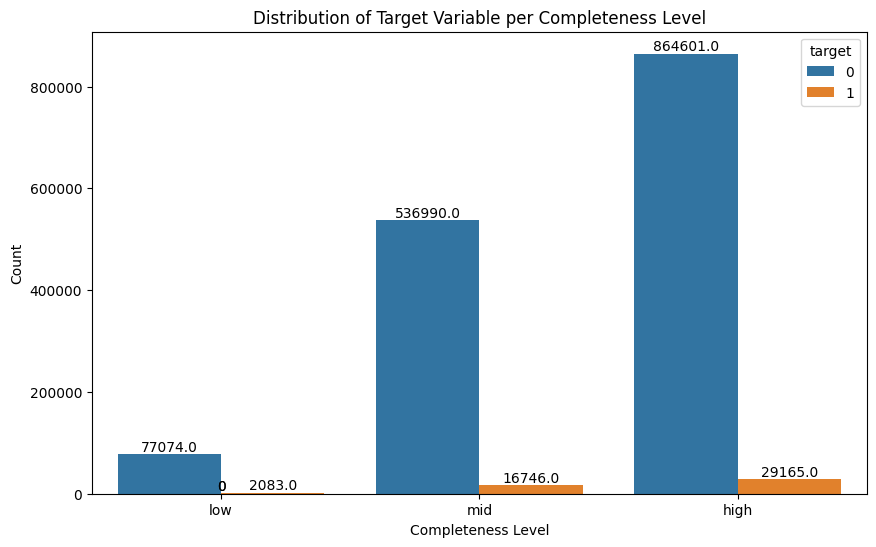

In [ ]:
# prompt: plot distribution of 'target' per completeness_level, show count on top of each bar

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is already defined and contains 'target' and 'completeness_level' columns
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='completeness_level', hue='target', data=df)
plt.title('Distribution of Target Variable per Completeness Level')
plt.xlabel('Completeness Level')
plt.ylabel('Count')

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()


In [ ]:
# prompt: group by completeness level, show count of target = 0,   target  = 1, and % of target = 1

# Assuming 'df' is already defined and contains 'target' and 'completeness_level' columns
completeness_summary = df.groupby('completeness_level')['target'].agg(['value_counts'])
completeness_summary = completeness_summary.unstack()
completeness_summary.columns = completeness_summary.columns.droplevel(0)
completeness_summary['%_target_0'] = (completeness_summary[0] / (completeness_summary[0] + completeness_summary[1])) * 100
completeness_summary['%_target_1'] = (completeness_summary[1] / (completeness_summary[0] + completeness_summary[1])) * 100
completeness_summary


<ipython-input-14-b5a660268458>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completeness_summary = df.groupby('completeness_level')['target'].agg(['value_counts'])


target,0,1,%_target_0,%_target_1
completeness_level,,,,
low,77074,2083,97.368521,2.631479
mid,536990,16746,96.975815,3.024185
high,864601,29165,96.736842,3.263158


In [ ]:
# Separate target variable
weeks = df["WEEK_NUM"]
case_id = df["case_id"]

X = df.drop(columns=["target", "case_id", "WEEK_NUM","completeness"], axis=1)
y = df['target']


# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y.value_counts()

,count
target,
0,1478665
1,47994


## Hyperparam tuning - balanced_df
with downsample majority class + stratified sample 1% + keep completeness level same

In [ ]:
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

# Assuming df is your original DataFrame
sub_df = df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

# Calculate the class weights for the target variable
class_weights = compute_class_weight(class_weight='balanced', classes=df['target'].unique(), y=df['target'])

# Get the majority and minority class labels
majority_class = sub_df['target'].value_counts().index[0]
minority_class = sub_df['target'].value_counts().index[1]

# Split the data into majority and minority classes
majority_df = sub_df[sub_df['target'] == majority_class]
minority_df = sub_df[sub_df['target'] == minority_class]

# Downsample the majority class
downsampled_majority_df = resample(majority_df,
                                      replace=False,
                                      n_samples=len(minority_df),
                                      random_state=42,
                                      stratify=majority_df['completeness_level'])

# Combine the downsampled majority class with the minority class
balanced_df = pd.concat([downsampled_majority_df, minority_df])



<ipython-input-10-51f2f3fabdc9>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_df = df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))


In [ ]:
sub_df['target'].value_counts()

,count
target,
0,147866
1,4799


In [ ]:
class_weights

array([ 0.51622883, 15.904686  ])

In [ ]:
balanced_df['target'].value_counts()
balanced_df['completeness_level'].value_counts()

,count
target,
0,4799
1,4799


,count
completeness_level,
high,5704
mid,3430
low,464


In [ ]:
# prompt: export balanced_df

# Export the balanced_df DataFrame to a CSV file
balanced_df.to_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/balanced_df.csv', index=False)


In [ ]:
balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/balanced_df.csv')


<ipython-input-8-3b1a56ad1ac3>:1: DtypeWarning: Columns (326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/balanced_df.csv')


In [ ]:
X = balanced_df.drop(columns=["target", "case_id", "WEEK_NUM","completeness"], axis=1)
y = balanced_df['target']


In [ ]:
y.value_counts()

,count
target,
0,4799
1,4799


In [ ]:
X['completeness_level'].value_counts()

,count
completeness_level,
high,5704
mid,3430
low,464


## Downsampling majority class

In [ ]:
from sklearn.utils import resample


# Group data by 'completeness_level'
grouped = df.groupby('completeness_level')

# Initialize an empty list to store the downsampled DataFrames
downsampled_dfs = []

# Iterate over each group
for name, group in grouped:
    # Separate target variable
    majority_class = group['target'].value_counts().index[0]
    minority_class = group['target'].value_counts().index[1]
    majority_df = group[group['target'] == majority_class]
    minority_df = group[group['target'] == minority_class]

    # Downsample the majority class within the current group
    downsampled_majority_df = resample(majority_df,
                                          replace=False,
                                          n_samples=len(minority_df),
                                          random_state=42)
    # Combine the downsampled majority class with the minority class
    balanced_group = pd.concat([downsampled_majority_df, minority_df])

    downsampled_dfs.append(balanced_group)

# Concatenate all the downsampled groups back into a single DataFrame
full_balanced_df = pd.concat(downsampled_dfs)




<ipython-input-56-0803c7c00e02>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('completeness_level')


In [ ]:
full_balanced_df['target'].value_counts()
full_balanced_df['completeness_level'].value_counts()

,count
target,
0,47994
1,47994


,count
completeness_level,
high,58330
mid,33492
low,4166


In [ ]:
full_balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/full_balanced_df.csv')

<ipython-input-8-f6eb06f8cafc>:1: DtypeWarning: Columns (261,272,289,294,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  full_balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/full_balanced_df.csv')


In [ ]:
full_balanced_df['target'].value_counts()
full_balanced_df['completeness_level'].value_counts()

,count
target,
0,47994
1,47994


,count
completeness_level,
high,58330
mid,33492
low,4166


In [ ]:
X = full_balanced_df.drop(columns=["target", "case_id", "WEEK_NUM","completeness"], axis=1)
y = full_balanced_df['target']


In [ ]:
y.value_counts()

,count
target,
0,47994
1,47994


In [ ]:
X['completeness_level'].value_counts()

,count
completeness_level,
high,58330
mid,33492
low,4166


#Model Setup

### XGBoost Setup


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
def optimize_trial(trial, X, y):
    model_name = 'XGBoost'

    model = xgb.XGBClassifier(random_state=42)
    params = {
        "verbosity": 0,
        # defines booster, gblinear for linear functions.
        #"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    # Set the hyperparameters
    model.set_params(**params)

    # Define the cross-validation strategy
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store the metrics
    f1_scores = []
    precision_scores = []
    recall_scores = []
    roc_auc_scores = []
    accuracy_scores = []
    balanced_accuracy_scores = []

    # Perform cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]

        # Use iloc to access y using the integer positions
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Define the model with the hyperparameters
        model = xgb.XGBClassifier(**params, random_state=42)

        # Fit the model on the preprocessed training data
        model.fit(X_train, y_train)

        # Predict on the preprocessed validation data
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Convert predicted probabilities to class labels (0 and 1)
        y_pred_class = (y_pred_proba >= 0.5).astype(int)  # Convert to 0 and 1

        # Calculate the metrics
        f1 = f1_score(y_val, y_pred_class)
        precision = precision_score(y_val, y_pred_class, zero_division=0)
        recall = recall_score(y_val, y_pred_class)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        accuracy = accuracy_score(y_val, y_pred_class)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred_class)

        # Append the metrics to the lists
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        roc_auc_scores.append(roc_auc)
        accuracy_scores.append(accuracy)
        balanced_accuracy_scores.append(balanced_accuracy)

    # Calculate the average metrics
    avg_f1 = np.mean(f1_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_roc_auc = np.mean(roc_auc_scores)
    avg_accuracy = np.mean(accuracy_scores)
    avg_balanced_accuracy = np.mean(balanced_accuracy_scores)

    # Set the user attributes
    trial.set_user_attr('metrics', {
        'f1': avg_f1,
        'precision': avg_precision,
        'recall': avg_recall,
        'roc_auc': avg_roc_auc,
        'accuracy': avg_accuracy,
        'balanced_accuracy': avg_balanced_accuracy
    })

    # Return the average F1-score as the objective value
    return avg_f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: optimize_trial(trial, X_train, y_train), n_trials=50)

[I 2025-02-13 21:33:30,955] A new study created in memory with name: no-name-f55168eb-08d7-4b56-a349-7fda861e0f41
[I 2025-02-13 21:33:38,150] Trial 0 finished with value: 0.7449143103235191 and parameters: {'lambda': 1.209096301532372e-05, 'alpha': 2.32135315626207e-08, 'subsample': 0.9236948912357781, 'colsample_bytree': 0.5854295416915822}. Best is trial 0 with value: 0.7449143103235191.
[I 2025-02-13 21:33:45,373] Trial 1 finished with value: 0.7370258354814203 and parameters: {'lambda': 4.4193005449736504e-06, 'alpha': 2.482580462013518e-06, 'subsample': 0.9033731989653013, 'colsample_bytree': 0.4766504013178038}. Best is trial 0 with value: 0.7449143103235191.
[I 2025-02-13 21:33:52,696] Trial 2 finished with value: 0.7292320147635603 and parameters: {'lambda': 0.0001434657272830324, 'alpha': 5.530292572668278e-07, 'subsample': 0.8052599049271698, 'colsample_bytree': 0.6869521174667557}. Best is trial 0 with value: 0.7449143103235191.
[I 2025-02-13 21:34:01,474] Trial 3 finished w

In [ ]:
best_trial = study.best_trial
print('Best parameters:', best_trial.params)
print('Best metrics:', best_trial.user_attrs)

Best parameters: {'lambda': 0.017012248373049627, 'alpha': 0.022505307324397275, 'subsample': 0.9000444900094916, 'colsample_bytree': 0.604810310088773}
Best metrics: {'metrics': {'f1': 0.7453477509524192, 'precision': 0.733590351277287, 'recall': 0.7576513914370006, 'roc_auc': 0.8082952099551981, 'accuracy': 0.7399066062703583, 'balanced_accuracy': 0.739820460116406}}


In [ ]:
XGB_results = []

for trial in study.trials:
    metrics = trial.user_attrs['metrics']
    params = trial.params
    XGB_results.append({
        'Trial': trial.number,
        'F1-score': metrics['f1'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'ROC-AUC': metrics['roc_auc'],
        'Accuracy': metrics['accuracy'],
        'balanced_accuracy': metrics['balanced_accuracy'],

        #"booster": params["booster"],
        "lambda": params["lambda"],
        "alpha": params["alpha"],
        "subsample": params["subsample"],
        "colsample_bytree": params["colsample_bytree"]
    })


In [ ]:
df_metrics_XGB = pd.DataFrame(XGB_results)
df_metrics_XGB

,Trial,F1-score,Precision,Recall,ROC-AUC,Accuracy,balanced_accuracy,lambda,alpha,subsample,colsample_bytree
0,0,0.744914,0.732380,0.758170,0.812898,0.739126,0.739033,1.209096e-05,2.321353e-08,0.923695,0.585430
1,1,0.737026,0.727091,0.747540,0.805581,0.731961,0.731885,4.419301e-06,2.482580e-06,0.903373,0.476650
2,2,0.729232,0.722384,0.736393,0.802426,0.725187,0.725134,1.434657e-04,5.530293e-07,0.805260,0.686952
3,3,0.721708,0.720756,0.722924,0.787465,0.719980,0.719970,2.307719e-06,3.036456e-05,0.489540,0.773996
4,4,0.729630,0.723315,0.736400,0.801658,0.725841,0.725792,1.839905e-01,1.330465e-02,0.617359,0.934394
5,5,0.735290,0.721650,0.749613,0.804869,0.728705,0.728602,1.830144e-06,5.338047e-02,0.885846,0.867690
6,6,0.724695,0.718074,0.731734,0.795653,0.720760,0.720710,2.552831e-05,9.089698e-08,0.556469,0.409066
7,7,0.732474,0.727263,0.737949,0.802125,0.729095,0.729053,2.243610e-02,2.283302e-01,0.685940,0.322058
8,8,0.742579,0.737715,0.748065,0.810808,0.739516,0.739478,3.240183e-01,5.193492e-01,0.626587,0.331461
9,9,0.703830,0.700273,0.707627,0.769064,0.700834,0.700803,6.158236e-02,1.920521e-01,0.288494,0.665559


In [ ]:
df_metrics_XGB.to_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/df_metrics_XGB.csv', index=False)


In [ ]:
import joblib
joblib.dump(study, '/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/optuna_XGB_study.pkl')

In [ ]:
def average_metrics(df_metrics):
    average_metrics = df_metrics[['F1-score', 'Precision', 'Recall', 'ROC-AUC','balanced_accuracy','Accuracy']].mean()
    return average_metrics


In [ ]:
def graph_metric_score(df_metrics):
  plt.figure(figsize=(12, 8))

  metrics = ['F1-score', 'Precision', 'Recall', 'ROC-AUC','balanced_accuracy','Accuracy']
  for metric in metrics:
      sns.lineplot(x='Trial', y=metric, data=df_metrics, label=metric)

  plt.title('Performance Metrics across Trials')
  plt.xlabel('Trial Number')
  plt.ylabel('Metric Value')
  plt.legend()
  plt.grid(True)
  plt.show()


In [ ]:
df_metrics_XGB = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/df_metrics_XGB.csv')

NameError: name 'pd' is not defined

In [ ]:
average_metrics(df_metrics_XGB)
graph_metric_score(df_metrics_XGB)

#### Fit with best params on 1% sample data

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 99.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# prompt: set up the xgboost classifier with best params

import joblib
import xgboost as xgb

# Load the study object
study = joblib.load('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/optuna_XGB_study.pkl')

# Access the best hyperparameters
best_params = study.best_params

# Initialize and set up the XGBoost classifier with the best parameters
best_model = xgb.XGBClassifier(random_state=42, **best_params)



In [ ]:
best_params

{'lambda': 0.017012248373049627,
 'alpha': 0.022505307324397275,
 'subsample': 0.9000444900094916,
 'colsample_bytree': 0.604810310088773}

In [ ]:
# prompt: sklearn and xgb version

import sklearn
import xgboost

print(f"scikit-learn version: {sklearn.__version__}")
print(f"xgboost version: {xgboost.__version__}")


scikit-learn version: 1.3.1
xgboost version: 2.1.4


In [ ]:
X_preprocessed = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/X_preprocessed.csv')
X_preprocessed


,0,1,2,3,4,5,6,7,8,9,...,587,588,589,590,591,592,593,594,595,596
0,12.0,6.0,38796.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.499739,0.510854,0.510854,0.510854,0.487491,0.487036,0.510854,0.510854,0.398058,0.505785
1,5.0,7.0,25978.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.499739,0.488973,0.488973,0.542077,0.487491,0.487036,0.486289,0.539804,0.490592,0.505785
2,8.0,5.0,36746.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.499739,0.510854,0.510854,0.510854,0.626030,0.518740,0.510854,0.510854,0.517086,0.461207
3,1.0,4.0,20998.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,...,0.499739,0.488973,0.488973,0.542077,0.487491,0.487036,0.486289,0.457123,0.490592,0.505785
4,3.0,4.0,20714.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.499739,0.488973,0.488973,0.542077,0.487491,0.487036,0.486289,0.457123,0.490592,0.495627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9593,12.0,5.0,56000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.499739,0.510854,0.510854,0.510854,0.413907,0.518740,0.510854,0.510854,0.517086,0.505785
9594,1.0,7.0,44178.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.499739,0.488973,0.488973,0.532297,0.487491,0.487036,0.486289,0.539804,0.490592,0.495627
9595,12.0,7.0,56596.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,...,0.499739,0.510854,0.510854,0.510854,0.487491,0.487036,0.510854,0.510854,0.490592,0.505785
9596,6.0,5.0,40000.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,...,0.499739,0.510854,0.510854,0.510854,0.487491,0.487036,0.510854,0.510854,0.398058,0.505785


In [ ]:
balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/balanced_df.csv')


<ipython-input-11-3b1a56ad1ac3>:1: DtypeWarning: Columns (326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/balanced_df.csv')


In [ ]:
X = balanced_df.drop(columns=["target", "case_id", "WEEK_NUM","completeness"], axis=1)
y = balanced_df['target']


In [ ]:
y.value_counts()

,count
target,
0,4799
1,4799


In [ ]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [ ]:
params = {'lambda': 0.017012248373049627,
 'alpha': 0.022505307324397275,
 'subsample': 0.9000444900094916,
 'colsample_bytree': 0.604810310088773}

model = xgb.XGBClassifier(**params, random_state=42)

# Fit the model on the preprocessed training data
model.fit(X_train, y_train)

# Predict on the preprocessed validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

XGBClassifier(alpha=0.022505307324397275, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.604810310088773, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.017012248373049627,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [ ]:
X_preprocessed = pd.DataFrame(X_preprocessed, index=X.index)
X_train4_index, X_test4_index, y_train4_index, y_test4_index = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [ ]:
result_balanced_df = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_proba}).set_index(test_index)
result_balanced_df = result_balanced_df.merge(balanced_df, left_index=True, right_index=True, how='left')
result_balanced_df


,y_test,y_pred_proba,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,...,last_contaddr_matchlist_1032L,last_contaddr_smempladdr_334L,last_incometype_1044T,last_relationshiptoclient_642T,last_role_1084L,last_safeguarantyflag_411L,last_sex_738L,last_type_25L,completeness,completeness_level
1318,0,0.787251,2553579,11,0,3,2,150000.000,0.0,0.0,...,False,False,OTHER,NaN,CL,True,M,PRIMARY_MOBILE,87.031700,high
9502,1,0.863369,1556528,38,1,9,6,29596.000,0.0,1.0,...,False,False,PRIVATE_SECTOR_EMPLOYEE,NaN,CL,True,F,PRIMARY_MOBILE,93.083573,high
8942,1,0.544719,1459049,29,1,7,2,38758.000,0.0,0.0,...,False,False,SALARIED_GOVT,NaN,CL,True,F,PRIMARY_MOBILE,89.913545,high
8248,1,0.993501,1798935,60,1,2,3,56996.000,0.0,0.0,...,False,False,RETIRED_PENSIONER,NaN,CL,True,F,PRIMARY_MOBILE,90.778098,high
6761,1,0.935922,174597,44,1,11,7,150000.000,0.0,0.0,...,NaN,NaN,NaN,CHILD,PE,NaN,NaN,PHONE,91.354467,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,1,0.924326,1374114,20,1,5,3,46942.402,0.0,0.0,...,False,False,SALARIED_GOVT,NaN,CL,True,F,PRIMARY_MOBILE,83.285303,high
3855,0,0.106739,1342361,15,0,4,2,13376.000,0.0,0.0,...,False,False,PRIVATE_SECTOR_EMPLOYEE,NaN,CL,True,F,PRIMARY_MOBILE,84.149856,high
5725,1,0.240214,953423,57,1,2,5,11400.000,0.0,0.0,...,NaN,NaN,NaN,FRIEND,PE,NaN,NaN,PHONE,71.757925,mid
6621,1,0.270628,2543499,6,1,2,6,22000.000,0.0,0.0,...,False,False,PRIVATE_SECTOR_EMPLOYEE,NaN,CL,True,F,PRIMARY_MOBILE,80.691643,high


In [ ]:
result_balanced_df.to_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/XGB_result_balanced_df.csv', index=False)


##### with completeness level

In [ ]:
result_balanced_df['completeness_level'].value_counts()

,count
completeness_level,
high,1119
mid,713
low,88


In [ ]:
# Create three sub-dataframes based on completeness levels
df_low = result_balanced_df[result_balanced_df['completeness_level'] == 'low']
df_mid = result_balanced_df[result_balanced_df['completeness_level'] == 'mid']
df_high = result_balanced_df[result_balanced_df['completeness_level'] == 'high']

In [ ]:
def calculate_metrics(y_val, y_pred_proba):
    # Convert predicted probabilities to class labels (0 and 1)
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    # Calculate the metrics
    metrics = {
        'Metric': ['F1 Score', 'Precision', 'Recall', 'ROC AUC', 'Accuracy', 'Balanced Accuracy'],
        'Value': [f1_score(y_val, y_pred_class),
                   precision_score(y_val, y_pred_class, zero_division=0),
                   recall_score(y_val, y_pred_class),
                   roc_auc_score(y_val, y_pred_proba),
                   accuracy_score(y_val, y_pred_class),
                   balanced_accuracy_score(y_val, y_pred_class)]
    }

    # Create a DataFrame
    df = pd.DataFrame(metrics)

    return df

In [ ]:
calculate_metrics(result_balanced_df['target'], result_balanced_df['y_pred_proba'])

,Metric,Value
0,F1 Score,0.729799
1,Precision,0.707585
2,Recall,0.753454
3,ROC AUC,0.801396
4,Accuracy,0.726562
5,Balanced Accuracy,0.727084


In [ ]:
metrics_low = calculate_metrics(df_low['target'], df_low['y_pred_proba'])
metrics_mid = calculate_metrics(df_mid['target'], df_mid['y_pred_proba'])
metrics_high = calculate_metrics(df_high['target'], df_high['y_pred_proba'])

metrics_low['completeness_level'] = 'low'
metrics_mid['completeness_level'] = 'mid'
metrics_high['completeness_level'] = 'high'

metrics_low = metrics_low.rename(columns={'Value': 'low'})
metrics_mid = metrics_mid.rename(columns={'Value': 'mid'})
metrics_high = metrics_high.rename(columns={'Value': 'high'})

combined_metrics = metrics_low.merge(metrics_mid, on='Metric', suffixes=('_low', '_mid'))
combined_metrics = combined_metrics.merge(metrics_high, on='Metric', suffixes=('', '_high'))

combined_metrics = combined_metrics.drop(columns=['completeness_level_low', 'completeness_level_mid', 'completeness_level'])
combined_metrics = combined_metrics.set_index('Metric')

combined_metrics


,low,mid,high
Metric,,,
F1 Score,0.477612,0.747638,0.733040
Precision,0.470588,0.730871,0.706282
Recall,0.484848,0.765193,0.761905
ROC AUC,0.695317,0.806945,0.804208
Accuracy,0.602273,0.737728,0.729223
Balanced Accuracy,0.578788,0.737298,0.729993


#### Fit with best params on full df


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 20.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# prompt: set up the xgboost classifier with best params

import joblib
import xgboost as xgb

# Load the study object
study = joblib.load('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/optuna_XGB_study.pkl')

# Access the best hyperparameters
best_params = study.best_params

# Initialize and set up the XGBoost classifier with the best parameters
best_model = xgb.XGBClassifier(random_state=42, **best_params)



In [ ]:
best_params

{'lambda': 0.017012248373049627,
 'alpha': 0.022505307324397275,
 'subsample': 0.9000444900094916,
 'colsample_bytree': 0.604810310088773}

In [ ]:
# prompt: sklearn and xgb version

import sklearn
import xgboost

print(f"scikit-learn version: {sklearn.__version__}")
print(f"xgboost version: {xgboost.__version__}")


scikit-learn version: 1.3.1
xgboost version: 2.1.4


In [ ]:
X_preprocessed = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Fulldf_X_preprocessed.csv')
X_preprocessed


,0,1,2,3,4,5,6,7,8,9,...,587,588,589,590,591,592,593,594,595,596
0,1.0,4.0,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026464,0.031454,0.032809,0.032809,0.032809,0.048534,0.034024,0.032809,0.032809,0.033845
1,1.0,4.0,19999.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039695,0.031454,0.032809,0.032809,0.032809,0.036505,0.034024,0.032809,0.032809,0.033845
2,1.0,5.0,78000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026464,0.031454,0.032809,0.032809,0.032809,0.021817,0.034024,0.032809,0.032809,0.033845
3,1.0,4.0,40000.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,...,0.026464,0.031454,0.032809,0.032809,0.032809,0.021817,0.034024,0.032809,0.032809,0.033845
4,1.0,5.0,44000.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.026464,0.031454,0.032809,0.032809,0.032809,0.040151,0.034024,0.032809,0.032809,0.033845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,10.0,1.0,30000.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.026464,0.031454,0.030111,0.030112,0.018666,0.029806,0.029655,0.029995,0.026257,0.030105
1526655,10.0,1.0,100000.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,...,0.026464,0.031454,0.032809,0.032809,0.032809,0.029806,0.029655,0.032809,0.032809,0.020478
1526656,10.0,1.0,60000.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.039695,0.031454,0.030111,0.030112,0.037642,0.029806,0.029655,0.032550,0.037092,0.030105
1526657,10.0,1.0,6000.0,0.0,0.0,36.0,0.0,9.0,1.0,0.0,...,0.026464,0.031454,0.032809,0.032809,0.032809,0.029806,0.029655,0.032809,0.032809,0.020478


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/df_train.csv')


<ipython-input-32-ed6b326a3e4e>:1: DtypeWarning: Columns (256,257,258,259,260,261,272,289,294,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,326,327,328,329,336,339,340,341,344,345) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/df_train.csv')


In [ ]:
df['completeness'] = (1 - df.isnull().sum(axis=1) / len(df.columns)) * 100

In [ ]:
df['completeness_level'] = pd.cut(df['completeness'], bins=[0, 40, 80, 100], labels=['low', 'mid', 'high'], right=False)

# Display the first few rows to verify the new column
print(df[['completeness', 'completeness_level']].head())

   completeness completeness_level
0     27.953890                low
1     27.953890                low
2     42.939481                mid
3     43.227666                mid
4     41.498559                mid


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 349 entries, case_id to completeness_level
dtypes: category(1), float64(250), int64(7), object(91)
memory usage: 4.0+ GB


In [ ]:
X = df.drop(columns=["target", "case_id", "WEEK_NUM","completeness"], axis=1)
y = df['target']


In [ ]:
y.value_counts()

,count
target,
0,1478665
1,47994


In [ ]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [ ]:
X_preprocessed = pd.DataFrame(X_preprocessed, index=X.index)
X_train4_index, X_test4_index, y_train4_index, y_test4_index = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [ ]:
train_index = X_train4_index.index
test_index = X_test4_index.index

In [ ]:
test_index

Index([1322328,  597755, 1325416,  877847,  210557,  522239, 1214334,  200141,
       1003401,  782552,
       ...
       1070835,  572087,  905253,  513283, 1318491, 1078208,   37805, 1160004,
        828383, 1215656],
      dtype='int64', length=305332)

In [ ]:
y_test

,target
1322328,0
597755,0
1325416,0
877847,0
210557,0
...,...
1078208,0
37805,0
1160004,0
828383,0


In [ ]:
y_test4_index

,target
1322328,0
597755,0
1325416,0
877847,0
210557,0
...,...
1078208,0
37805,0
1160004,0
828383,0


In [ ]:
params = {'lambda': 0.017012248373049627,
 'alpha': 0.022505307324397275,
 'subsample': 0.9000444900094916,
 'colsample_bytree': 0.604810310088773}

model = xgb.XGBClassifier(**params, random_state=42)

# Fit the model on the preprocessed training data
model.fit(X_train, y_train)

# Predict on the preprocessed validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

XGBClassifier(alpha=0.022505307324397275, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.604810310088773, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.017012248373049627,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [ ]:
result_full_df = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_proba}).set_index(test_index)
result_full_df = result_full_df.merge(df, left_index=True, right_index=True, how='left')
result_full_df


,y_test,y_pred_proba,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,...,last_contaddr_matchlist_1032L,last_contaddr_smempladdr_334L,last_incometype_1044T,last_relationshiptoclient_642T,last_role_1084L,last_safeguarantyflag_411L,last_sex_738L,last_type_25L,completeness,completeness_level
1322328,0,0.000788,1916357,87,0,9,4,76986.0,0.0,0.0,...,False,False,RETIRED_PENSIONER,NaN,CL,True,F,PRIMARY_MOBILE,85.878963,high
597755,0,0.003791,982288,71,0,5,3,21000.0,0.0,0.0,...,NaN,NaN,NaN,OTHER_RELATIVE,PE,NaN,NaN,PHONE,71.469741,mid
1325416,0,0.001401,1919445,87,0,9,6,26900.0,0.0,0.0,...,False,False,RETIRED_PENSIONER,NaN,CL,True,M,PRIMARY_MOBILE,90.201729,high
877847,0,0.006479,1471876,30,0,8,5,36580.0,0.0,0.0,...,False,False,EMPLOYED,NaN,CL,True,F,PRIMARY_MOBILE,89.337176,high
210557,0,0.002697,255991,90,0,9,2,70000.0,0.0,0.0,...,False,False,RETIRED_PENSIONER,NaN,CL,True,F,PRIMARY_MOBILE,91.066282,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078208,0,0.002579,1672237,48,0,12,6,76360.0,0.0,0.0,...,NaN,NaN,NaN,NaN,EM,NaN,NaN,PHONE,90.201729,high
37805,0,0.140776,37805,45,0,11,5,200000.0,0.0,4.0,...,NaN,NaN,NaN,SIBLING,PE,NaN,NaN,PHONE,69.452450,mid
1160004,0,0.007047,1754033,54,0,1,6,84372.0,0.0,0.0,...,False,False,SALARIED_GOVT,NaN,CL,True,F,PRIMARY_MOBILE,90.201729,high
828383,0,0.004586,1422412,25,0,6,5,11998.0,0.0,0.0,...,False,False,SELFEMPLOYED,NaN,CL,True,F,PRIMARY_MOBILE,90.778098,high


In [ ]:
result_full_df.to_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/XGB_result_full_df.csv', index=False)


##### with completeness level

In [ ]:
result_full_df['completeness_level'].value_counts()

,count
completeness_level,
high,179306
mid,110360
low,15666


In [ ]:
# Create three sub-dataframes based on completeness levels
df_low = result_full_df[result_full_df['completeness_level'] == 'low']
df_mid = result_full_df[result_full_df['completeness_level'] == 'mid']
df_high = result_full_df[result_full_df['completeness_level'] == 'high']


In [ ]:
def calculate_metrics(y_val, y_pred_proba):
    # Convert predicted probabilities to class labels (0 and 1)
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    # Calculate the metrics
    metrics = {
        'Metric': ['F1 Score', 'Precision', 'Recall', 'ROC AUC', 'Accuracy', 'Balanced Accuracy'],
        'Value': [f1_score(y_val, y_pred_class),
                   precision_score(y_val, y_pred_class, zero_division=0),
                   recall_score(y_val, y_pred_class),
                   roc_auc_score(y_val, y_pred_proba),
                   accuracy_score(y_val, y_pred_class),
                   balanced_accuracy_score(y_val, y_pred_class)]
    }

    # Create a DataFrame
    df = pd.DataFrame(metrics)

    return df

In [ ]:
calculate_metrics(result_full_df['target'], result_full_df['y_pred_proba'])

,Metric,Value
0,F1 Score,0.058595
1,Precision,0.400000
2,Recall,0.031613
3,ROC AUC,0.847170
4,Accuracy,0.968218
5,Balanced Accuracy,0.515041


In [ ]:
metrics_low = calculate_metrics(df_low['target'], df_low['y_pred_proba'])
metrics_mid = calculate_metrics(df_mid['target'], df_mid['y_pred_proba'])
metrics_high = calculate_metrics(df_high['target'], df_high['y_pred_proba'])

metrics_low['completeness_level'] = 'low'
metrics_mid['completeness_level'] = 'mid'
metrics_high['completeness_level'] = 'high'

metrics_low = metrics_low.rename(columns={'Value': 'low'})
metrics_mid = metrics_mid.rename(columns={'Value': 'mid'})
metrics_high = metrics_high.rename(columns={'Value': 'high'})

combined_metrics = metrics_low.merge(metrics_mid, on='Metric', suffixes=('_low', '_mid'))
combined_metrics = combined_metrics.merge(metrics_high, on='Metric', suffixes=('', '_high'))

combined_metrics = combined_metrics.drop(columns=['completeness_level_low', 'completeness_level_mid', 'completeness_level'])
combined_metrics = combined_metrics.set_index('Metric')

combined_metrics


,low,mid,high
Metric,,,
F1 Score,0.019048,0.044173,0.068869
Precision,0.500000,0.455090,0.382759
Recall,0.009709,0.023213,0.037839
ROC AUC,0.763637,0.839768,0.855882
Accuracy,0.973701,0.970198,0.966521
Balanced Accuracy,0.504723,0.511182,0.517887


#### Fit with best params on full_balanced_df


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 99.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# prompt: set up the xgboost classifier with best params

import joblib
import xgboost as xgb

# Load the study object
study = joblib.load('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/optuna_XGB_study.pkl')

# Access the best hyperparameters
best_params = study.best_params

# Initialize and set up the XGBoost classifier with the best parameters
best_model = xgb.XGBClassifier(random_state=42, **best_params)



In [ ]:
best_params

{'lambda': 0.017012248373049627,
 'alpha': 0.022505307324397275,
 'subsample': 0.9000444900094916,
 'colsample_bytree': 0.604810310088773}

In [ ]:
# prompt: sklearn and xgb version

import sklearn
import xgboost

print(f"scikit-learn version: {sklearn.__version__}")
print(f"xgboost version: {xgboost.__version__}")


scikit-learn version: 1.3.1
xgboost version: 2.1.4


In [ ]:
X_preprocessed = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Full_balanced_df_X_preprocessed.csv')
X_preprocessed


,0,1,2,3,4,5,6,7,8,9,...,587,588,589,590,591,592,593,594,595,596
0,3.0,4.0,47937.8000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.455431,0.500021,0.515971,0.515971,0.515971,0.570655,0.525107,0.515971,0.515971,0.524211
1,7.0,3.0,17974.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.455431,0.500021,0.484216,0.484226,0.463334,0.483362,0.481169,0.497187,0.449022,0.485679
2,2.0,2.0,84576.0000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.455431,0.500021,0.515971,0.515971,0.515971,0.462197,0.525107,0.515971,0.515971,0.524211
3,5.0,6.0,7749.8003,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.455431,0.500021,0.515971,0.515971,0.515971,0.403364,0.525107,0.515971,0.515971,0.524211
4,4.0,1.0,23372.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.560738,0.500021,0.515971,0.515971,0.515971,0.570655,0.525107,0.515971,0.515971,0.524211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95983,10.0,5.0,61814.0000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.455431,0.500021,0.484216,0.484226,0.463334,0.483362,0.481169,0.497187,0.449022,0.485679
95984,10.0,5.0,100000.0000,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,0.560738,0.500021,0.484216,0.484226,0.525685,0.483362,0.481169,0.497187,0.538308,0.485679
95985,10.0,6.0,61814.0000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.455431,0.500021,0.484216,0.484226,0.463334,0.483362,0.481169,0.483564,0.449022,0.485679
95986,10.0,1.0,120000.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.455431,0.500021,0.484216,0.484226,0.525685,0.483362,0.481169,0.483564,0.449022,0.485679


In [ ]:
full_balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/full_balanced_df.csv')


<ipython-input-56-f6eb06f8cafc>:1: DtypeWarning: Columns (261,272,289,294,326,327) have mixed types. Specify dtype option on import or set low_memory=False.
  full_balanced_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/full_balanced_df.csv')


In [ ]:
X = full_balanced_df.drop(columns=["target", "case_id", "WEEK_NUM","completeness"], axis=1)
y = full_balanced_df['target']


In [ ]:
y.value_counts()

,count
target,
0,47994
1,47994


In [ ]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [ ]:
X_preprocessed = pd.DataFrame(X_preprocessed, index=X.index)
X_train4_index, X_test4_index, y_train4_index, y_test4_index = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [ ]:
train_index = X_train4_index.index
test_index = X_test4_index.index

In [ ]:
params = {'lambda': 0.017012248373049627,
 'alpha': 0.022505307324397275,
 'subsample': 0.9000444900094916,
 'colsample_bytree': 0.604810310088773}

model = xgb.XGBClassifier(**params, random_state=42)

# Fit the model on the preprocessed training data
model.fit(X_train, y_train)

# Predict on the preprocessed validation data
y_pred_proba = model.predict_proba(X_test)[:, 1]

XGBClassifier(alpha=0.022505307324397275, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.604810310088773, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.017012248373049627,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [ ]:
result_full_bal_df = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_proba}).set_index(test_index)
result_full_bal_df = result_full_bal_df.merge(full_balanced_df, left_index=True, right_index=True, how='left')
result_full_bal_df


,y_test,y_pred_proba,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,...,last_contaddr_matchlist_1032L,last_contaddr_smempladdr_334L,last_incometype_1044T,last_relationshiptoclient_642T,last_role_1084L,last_safeguarantyflag_411L,last_sex_738L,last_type_25L,completeness,completeness_level
55490,0,0.818197,2617376,35,0,9,5,62000.0,0.0,0.0,...,False,False,PRIVATE_SECTOR_EMPLOYEE,NaN,CL,True,F,PRIMARY_MOBILE,93.371758,high
22514,1,0.783544,103487,0,1,1,5,40000.0,0.0,0.0,...,NaN,NaN,NaN,FRIEND,PE,NaN,NaN,PHONE,57.925072,mid
67138,1,0.562388,126802,17,1,5,6,64000.0,0.0,0.0,...,NaN,NaN,NaN,CHILD,PE,NaN,NaN,PHONE,84.726225,high
5346,0,0.665310,782178,34,0,8,2,16738.0,0.0,0.0,...,NaN,NaN,NaN,NaN,CL,NaN,NaN,PRIMARY_MOBILE,71.181556,mid
23864,1,0.607702,627054,5,1,2,3,4100.0,0.0,1.0,...,NaN,NaN,NaN,SIBLING,PE,NaN,NaN,PHONE,59.654179,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37966,0,0.052566,2696966,87,0,9,6,15000.0,0.0,0.0,...,False,False,SALARIED_GOVT,NaN,CL,True,F,PRIMARY_MOBILE,87.319885,high
2001,0,0.279656,763667,31,0,8,3,23998.0,0.0,0.0,...,NaN,NaN,NaN,SIBLING,PE,NaN,NaN,PHONE,29.971182,low
32901,1,0.924335,1020830,89,1,9,3,47998.0,0.0,0.0,...,NaN,NaN,NaN,FRIEND,PE,NaN,NaN,PHONE,53.314121,mid
75248,1,0.501021,1440155,27,1,7,3,31343.0,0.0,0.0,...,False,False,SALARIED_GOVT,NaN,CL,True,F,PRIMARY_MOBILE,90.489914,high


In [ ]:
result_full_bal_df.to_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/XGB_result_full_bal_df.csv', index=False)


##### with completeness level

In [ ]:
result_full_bal_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/XGB_result_full_bal_df.csv')

<ipython-input-63-dbf5e2f2e447>:1: DtypeWarning: Columns (328,329) have mixed types. Specify dtype option on import or set low_memory=False.
  result_full_bal_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CreditFairness/HomeCreditStability/Results/XGB_result_full_bal_df.csv')


In [ ]:
result_full_bal_df['completeness_level'].value_counts()

,count
completeness_level,
high,11662
mid,6711
low,825


In [ ]:
# Create three sub-dataframes based on completeness levels
df_low = result_full_bal_df[result_full_bal_df['completeness_level'] == 'low']
df_mid = result_full_bal_df[result_full_bal_df['completeness_level'] == 'mid']
df_high = result_full_bal_df[result_full_bal_df['completeness_level'] == 'high']
df_full = result_full_bal_df

In [ ]:
def calculate_metrics(y_val, y_pred_proba):
    # Convert predicted probabilities to class labels (0 and 1)
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    # Calculate the metrics
    metrics = {
        'Metric': ['F1 Score', 'Precision', 'Recall', 'ROC AUC', 'Accuracy', 'Balanced Accuracy'],
        'Value': [f1_score(y_val, y_pred_class),
                   precision_score(y_val, y_pred_class, zero_division=0),
                   recall_score(y_val, y_pred_class),
                   roc_auc_score(y_val, y_pred_proba),
                   accuracy_score(y_val, y_pred_class),
                   balanced_accuracy_score(y_val, y_pred_class)]
    }

    # Create a DataFrame
    df = pd.DataFrame(metrics)

    return df

In [ ]:
calculate_metrics(result_full_bal_df['target'], result_full_bal_df['y_pred_proba'])

,Metric,Value
0,F1 Score,0.767416
1,Precision,0.754675
2,Recall,0.780594
3,ROC AUC,0.836499
4,Accuracy,0.761746
5,Balanced Accuracy,0.761612


In [ ]:
def combine_metrics(df_low, df_mid, df_high, df_full, calculate_metrics):
    """
    Combine metrics from different dataframes.

    Args:
        df_low (DataFrame): Low completeness level dataframe.
        df_mid (DataFrame): Mid completeness level dataframe.
        df_high (DataFrame): High completeness level dataframe.
        df_full (DataFrame): Full dataframe.
        calculate_metrics (function): Function to calculate metrics.

    Returns:
        DataFrame: Combined metrics dataframe.
    """

    # Calculate metrics
    metrics_low = calculate_metrics(df_low['target'], df_low['y_pred_proba'])
    metrics_mid = calculate_metrics(df_mid['target'], df_mid['y_pred_proba'])
    metrics_high = calculate_metrics(df_high['target'], df_high['y_pred_proba'])
    metrics_full = calculate_metrics(df_full['target'], df_full['y_pred_proba'])

    # Rename 'Value' columns
    metrics_low = metrics_low.rename(columns={'Value': 'low'})
    metrics_mid = metrics_mid.rename(columns={'Value': 'mid'})
    metrics_high = metrics_high.rename(columns={'Value': 'high'})
    metrics_full = metrics_full.rename(columns={'Value': 'full'})

    # Merge metrics
    combined_metrics = metrics_low.merge(metrics_mid, on='Metric').merge(metrics_high, on='Metric').merge(metrics_full, on='Metric')

    # Set index
    combined_metrics = combined_metrics.set_index('Metric')

    return combined_metrics

In [ ]:
combined_metrics = combine_metrics(df_low, df_mid, df_high, result_full_bal_df, calculate_metrics)
combined_metrics

,low,mid,high,full
Metric,,,,
F1 Score,0.681710,0.767048,0.773685,0.767416
Precision,0.689904,0.759026,0.756606,0.754675
Recall,0.673709,0.775241,0.791552,0.780594
ROC AUC,0.745761,0.835435,0.842738,0.836499
Accuracy,0.675152,0.760244,0.768736,0.761746
Balanced Accuracy,0.675200,0.759964,0.768763,0.761612


In [ ]:
combined_metrics.loc['F1 Score']

,F1 Score
low,0.681710
mid,0.767048
high,0.773685
full,0.767416


# Normality Tests
- For the Shapiro-Wilk Test, if the p-value is less than 0.05, you can reject the null hypothesis that the data is normally distributed.
- For the Q-Q Plot, if the points deviate significantly from the straight line, the data may not be normally distributed.
- For Levene's Test, if the p-value is less than 0.05, you can reject the null hypothesis that the variances are equal across all groups.

In [ ]:
low_data = combined_metrics['low']
mid_data = combined_metrics['mid']
high_data = combined_metrics['high']
full_data = combined_metrics['full']


In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# Shapiro-Wilk Test
stat, p = stats.shapiro(low_data)
print(f"Shapiro-Wilk Test: stat={stat:.4f}, p={p:.4f}")

stat, p = stats.shapiro(mid_data)
print(f"Shapiro-Wilk Test: stat={stat:.4f}, p={p:.4f}")

stat, p = stats.shapiro(high_data)
print(f"Shapiro-Wilk Test: stat={stat:.4f}, p={p:.4f}")


Shapiro-Wilk Test: stat=0.6710, p=0.0030
Shapiro-Wilk Test: stat=0.6622, p=0.0024
Shapiro-Wilk Test: stat=0.8017, p=0.0609


<Figure size 800x600 with 0 Axes>

((array([-1.23132171, -0.63003387, -0.19819716,  0.19819716,  0.63003387,
          1.23132171]),
  array([0.67370892, 0.67515152, 0.67520032, 0.68171021, 0.68990385,
         0.74576112])),
 (0.025431588030511845, 0.6902393227385777, 0.8065092551530781))

Text(0.5, 1.0, 'Q-Q Plot')

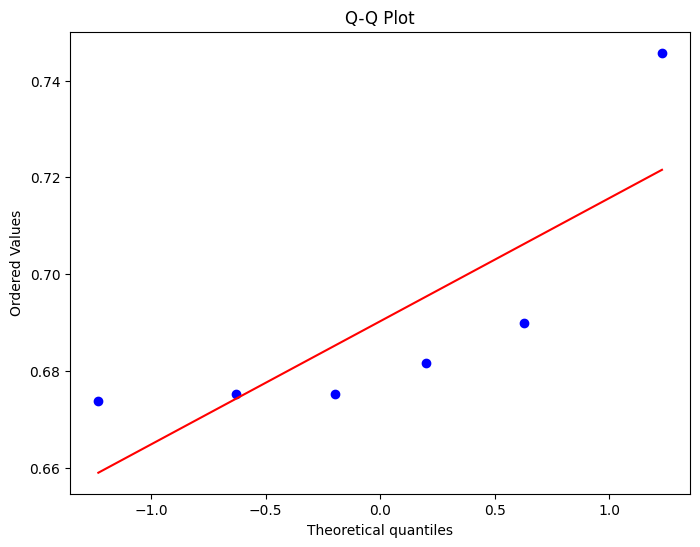

<Figure size 800x600 with 0 Axes>

((array([-1.23132171, -0.63003387, -0.19819716,  0.19819716,  0.63003387,
          1.23132171]),
  array([0.75902579, 0.75996438, 0.76024437, 0.76704792, 0.77524144,
         0.83543482])),
 (0.026905039949226443, 0.7761597868593838, 0.8009040862163335))

Text(0.5, 1.0, 'Q-Q Plot')

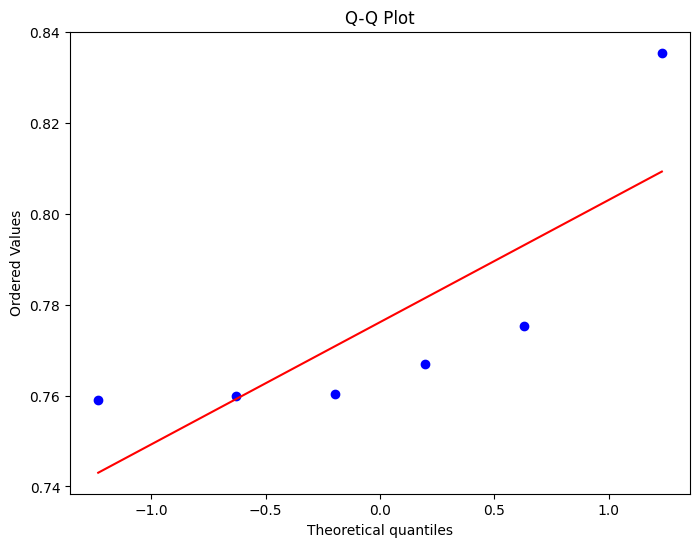

<Figure size 800x600 with 0 Axes>

((array([-1.23132171, -0.63003387, -0.19819716,  0.19819716,  0.63003387,
          1.23132171]),
  array([0.75660594, 0.76873607, 0.76876342, 0.77368465, 0.7915522 ,
         0.8427384 ])),
 (0.03109210314226054, 0.7836801129987464, 0.8841710680342151))

Text(0.5, 1.0, 'Q-Q Plot')

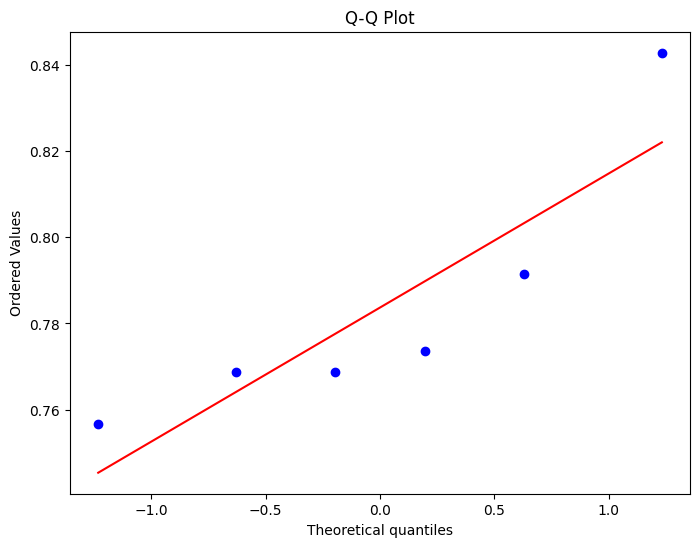

In [ ]:
# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(low_data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()


plt.figure(figsize=(8, 6))
stats.probplot(mid_data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(high_data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

In [ ]:
# Levene's Test
# Note: This test requires multiple groups of data
group1 = low_data
group2 = mid_data
group3 = high_data
stat, p = stats.levene(group1, group2, group3)
print(f"Levene's Test: stat={stat:.4f}, p={p:.4f}")

Levene's Test: stat=0.0270, p=0.9734


# Pairwise t-test

In [ ]:
import numpy as np
from scipy.stats import ttest_ind


In [ ]:
def compare_low_with_others(low_data, mid_data, high_data, full_data):
    """
    Compare 'low' data with 'mid', 'high', and 'full' data using pairwise t-tests.

    Args:
        low_data (array-like): Data for 'low' category.
        mid_data (array-like): Data for 'mid' category.
        high_data (array-like): Data for 'high' category.
        full_data (array-like): Data for 'full' category.

    Returns:
        None
    """

    # Define comparison pairs and labels
    pairs = [(mid_data, "Mid"), (high_data, "High"), (full_data, "Full")]

    # Perform pairwise t-tests and print results
    for data, label in pairs:
        t_stat, p_val = ttest_ind(low_data, data)
        print(f"Low vs {label}: t-stat={t_stat:.4f}, p-val={p_val:.4f}")

In [ ]:
low_data

,low
Metric,
F1 Score,0.681710
Precision,0.689904
Recall,0.673709
ROC AUC,0.745761
Accuracy,0.675152
Balanced Accuracy,0.675200


In [ ]:
compare_low_with_others(low_data, mid_data, high_data, full_data)

Low vs Mid: t-stat=-5.1689, p-val=0.0004
Low vs High: t-stat=-5.4835, p-val=0.0003
Low vs Full: t-stat=-5.1611, p-val=0.0004


# Pairwise t-test for all

In [ ]:
data = {
    "Model": ["DT", "RF", "LGBM", "XGB"] * 6,
    "Metric": ["Accuracy"] * 4 + ["Balanced Accuracy"] * 4 + ["F1 Score"] * 4 + ["Precision"] * 4 + ["Recall"] * 4 + ["ROC AUC"] * 4,
    "low": [0.612121212, 0.67030303, 0.686060606, 0.675,
            0.607813548, 0.669472978, 0.685604857, 0.675,
            0.663157895, 0.685185185, 0.697076023, 0.682,
            0.601145038, 0.675799087, 0.694638695, 0.690,
            0.73943662, 0.694835681, 0.699530516, 0.674,
            0.617718004, 0.731829574, 0.746778919, 0.746],
    "mid": [0.688571003, 0.748174639, 0.768886902, 0.760,
            0.688280578, 0.74781682, 0.768533311, 0.760,
            0.697189221, 0.756273435, 0.776351839, 0.767,
            0.690387374, 0.745521751, 0.765207504, 0.759,
            0.704126427, 0.767339772, 0.787825578, 0.775,
            0.747916192, 0.819237148, 0.844756005, 0.835],
    "high": [0.701166181, 0.75210084, 0.78305608, 0.769,
             0.701164, 0.752145879, 0.783090766, 0.769,
             0.700369702, 0.760856977, 0.788955622, 0.774,
             0.701394868, 0.734078212, 0.767196626, 0.757,
             0.699347527, 0.789663462, 0.81198489, 0.792,
             0.766045244, 0.829082309, 0.856157225, 0.843],
    "full": [0.692936764, 0.747213251, 0.773934785, 0.762,
             0.69286637, 0.746996497, 0.773759595, 0.762,
             0.697428527, 0.755971237, 0.780564263, 0.767,
             0.692135289, 0.735518591, 0.763425972, 0.755,
             0.702803352, 0.777593876, 0.798489707, 0.781,
             0.7552829, 0.82194881, 0.848352673, 0.836]
}

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df

,Model,Metric,low,mid,high,full
0,DT,Accuracy,0.612121,0.688571,0.701166,0.692937
1,RF,Accuracy,0.670303,0.748175,0.752101,0.747213
2,LGBM,Accuracy,0.686061,0.768887,0.783056,0.773935
3,XGB,Accuracy,0.675000,0.760000,0.769000,0.762000
4,DT,Balanced Accuracy,0.607814,0.688281,0.701164,0.692866
5,RF,Balanced Accuracy,0.669473,0.747817,0.752146,0.746996
6,LGBM,Balanced Accuracy,0.685605,0.768533,0.783091,0.773760
7,XGB,Balanced Accuracy,0.675000,0.760000,0.769000,0.762000
8,DT,F1 Score,0.663158,0.697189,0.700370,0.697429
9,RF,F1 Score,0.685185,0.756273,0.760857,0.755971


In [ ]:
models = df["Model"].unique()
metrics = df["Metric"].unique()

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np

for metric in metrics:
    for comparison in [("low", "mid"), ("low", "high"), ("low", "full"),
                        ("mid", "high"), ("mid", "full"), ("high", "full")]:
        values1 = df[(df["Metric"] == metric) & (df["Model"].isin(models))][comparison[0]].values
        values2 = df[(df["Metric"] == metric) & (df["Model"].isin(models))][comparison[1]].values

        # Perform the paired t-test
        t_stat, p_val = stats.ttest_rel(values1, values2)
        print(f"{metric}: {comparison[0]} vs {comparison[1]}, t-stat={t_stat:.4f}, p-val={p_val:.4f}")

Accuracy: low vs mid, t-stat=-39.8681, p-val=0.0000
Accuracy: low vs high, t-stat=-27.2457, p-val=0.0001
Accuracy: low vs full, t-stat=-31.9013, p-val=0.0001
Accuracy: mid vs high, t-stat=-4.3659, p-val=0.0222
Accuracy: mid vs full, t-stat=-1.9232, p-val=0.1502
Accuracy: high vs full, t-stat=7.9713, p-val=0.0041
Balanced Accuracy: low vs mid, t-stat=-56.3878, p-val=0.0000
Balanced Accuracy: low vs high, t-stat=-28.7148, p-val=0.0001
Balanced Accuracy: low vs full, t-stat=-35.3222, p-val=0.0000
Balanced Accuracy: mid vs high, t-stat=-4.4806, p-val=0.0207
Balanced Accuracy: mid vs full, t-stat=-1.9930, p-val=0.1403
Balanced Accuracy: high vs full, t-stat=8.2579, p-val=0.0037
F1 Score: low vs mid, t-stat=-5.8734, p-val=0.0098
F1 Score: low vs high, t-stat=-5.7472, p-val=0.0105
F1 Score: low vs full, t-stat=-5.7905, p-val=0.0102
F1 Score: mid vs high, t-stat=-3.2953, p-val=0.0459
F1 Score: mid vs full, t-stat=-0.9749, p-val=0.4015
F1 Score: high vs full, t-stat=4.8535, p-val=0.0167
Precisi

In [ ]:
import pandas as pd
from scipy import stats

results = []

for metric in metrics:
    for comparison in [("low", "mid"), ("low", "high"), ("low", "full"),
                        ("mid", "high"), ("mid", "full"), ("high", "full")]:
        values1 = df[(df["Metric"] == metric) & (df["Model"].isin(models))][comparison[0]].values
        values2 = df[(df["Metric"] == metric) & (df["Model"].isin(models))][comparison[1]].values

        # Perform the paired t-test
        t_stat, p_val = stats.ttest_rel(values1, values2)

        # Append the results to the list
        results.append({
            "Metric": metric,
            "Classes": f"{comparison[0]} vs {comparison[1]}",
            "t-stat": t_stat,
            "p-val": p_val
        })

# Convert the list to a DataFrame
df_results = pd.DataFrame(results)



In [ ]:
df_results

,Metric,Classes,t-stat,p-val
0,Accuracy,low vs mid,-39.868123,0.000035
1,Accuracy,low vs high,-27.245716,0.000109
2,Accuracy,low vs full,-31.901257,0.000068
3,Accuracy,mid vs high,-4.365939,0.022220
4,Accuracy,mid vs full,-1.923206,0.150164
5,Accuracy,high vs full,7.971332,0.004119
6,Balanced Accuracy,low vs mid,-56.387818,0.000012
7,Balanced Accuracy,low vs high,-28.714759,0.000093
8,Balanced Accuracy,low vs full,-35.322178,0.000050
9,Balanced Accuracy,mid vs high,-4.480632,0.020729


# One way ANOVA

In [ ]:
import pandas as pd
from scipy import stats

results = []

for metric in metrics:
    # Filter the data
    df_filtered = df[df["Metric"] == metric]

    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(df_filtered["low"], df_filtered["mid"], df_filtered["high"], df_filtered["full"])

    # Append the results to the list
    results.append({
        "Metric": metric,
        "F-stat": f_stat,
        "p-val": p_val
    })

# Convert the list to a DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame
df_results

,Metric,F-stat,p-val
0,Accuracy,5.832182,0.010722
1,Balanced Accuracy,5.855298,0.010579
2,F1 Score,4.570112,0.023457
3,Precision,4.387243,0.026501
4,Recall,2.595418,0.100838
5,ROC AUC,5.002974,0.017734


In [ ]:
results = []

for metric in metrics:
    # Filter the data
    df_filtered = df[df["Metric"] == metric]

    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(df_filtered["low"], df_filtered["mid"], df_filtered["high"])

    # Append the results to the list
    results.append({
        "Metric": metric,
        "F-stat": f_stat,
        "p-val": p_val
    })

# Convert the list to a DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame
df_results

,Metric,F-stat,p-val
0,Accuracy,8.001428,0.010073
1,Balanced Accuracy,7.956491,0.010237
2,F1 Score,6.777368,0.016015
3,Precision,5.685353,0.025326
4,Recall,3.646863,0.069183
5,ROC AUC,6.259114,0.019791
